## 1. Get the dataset

In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [3]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches

mpl.style.use('ggplot') # optional: for ggplot-like style
colors_list = ['#5cb85c','#5bc0de','#d9534f']

In [4]:
# load the data into a data frame
df=pd.read_csv("file:///Users/meihao/Desktop/la_neighborhoods.csv")
df.head()

,set,slug,the_geom,kind,external_i,name,display_na,sqmi,type,name_1,slug_1,latitude,longitude,location,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,L.A. County Neighborhoods (Current),acton,MULTIPOLYGON (((-118.20261747920541 34.5389897...,L.A. County Neighborhood (Current),acton,Acton,Acton L.A. County Neighborhood (Current),39.33910895,unincorporated-area,NaN,NaN,-118.1698102,34.497355,POINT(34.497355239240846 -118.16981019229348),NaN,NaN,NaN
1,L.A. County Neighborhoods (Current),adams-normandie,MULTIPOLYGON (((-118.30900800000012 34.0374109...,L.A. County Neighborhood (Current),adams-normandie,Adams-Normandie,Adams-Normandie L.A. County Neighborhood (Curr...,0.805350188,segment-of-a-city,NaN,NaN,-118.300208,34.031461,POINT(34.031461499124156 -118.30020800000011),NaN,NaN,NaN
2,L.A. County Neighborhoods (Current),agoura-hills,MULTIPOLYGON (((-118.76192500000009 34.1682029...,L.A. County Neighborhood (Current),agoura-hills,Agoura Hills,Agoura Hills L.A. County Neighborhood (Current),8.146760298,standalone-city,NaN,NaN,-118.7598845,34.146736,POINT(34.146736499122795 -118.75988450000015),NaN,NaN,NaN
3,L.A. County Neighborhoods (Current),agua-dulce,MULTIPOLYGON (((-118.2546773959221 34.55830403...,L.A. County Neighborhood (Current),agua-dulce,Agua Dulce,Agua Dulce L.A. County Neighborhood (Current),31.46263195,unincorporated-area,NaN,NaN,-118.3171037,34.504927,POINT(34.504926999796837 -118.3171036690717),NaN,NaN,NaN
4,L.A. County Neighborhoods (Current),alhambra,MULTIPOLYGON (((-118.12174700000014 34.1050399...,L.A. County Neighborhood (Current),alhambra,Alhambra,Alhambra L.A. County Neighborhood (Current),7.623814306,standalone-city,NaN,NaN,-118.136512,34.085539,POINT(34.085538999123571 -118.13651200000021),NaN,NaN,NaN


## 2. Data Cleaning

In [5]:
df_la = df[['name','latitude','longitude']]
df_la.head()

,name,latitude,longitude
0,Acton,-118.1698102,34.497355
1,Adams-Normandie,-118.300208,34.031461
2,Agoura Hills,-118.7598845,34.146736
3,Agua Dulce,-118.3171037,34.504927
4,Alhambra,-118.136512,34.085539


In [6]:
# drop the NA values
df_la = df_la.drop(df_la.index[[236,237]])
df_la.head()

,name,latitude,longitude
0,Acton,-118.1698102,34.497355
1,Adams-Normandie,-118.300208,34.031461
2,Agoura Hills,-118.7598845,34.146736
3,Agua Dulce,-118.3171037,34.504927
4,Alhambra,-118.136512,34.085539


In [7]:
# exchange the Lon with Lat columns since they are opposite
df_la = df_la.rename(columns={'name':'Neighborhood','latitude':'Longitude','longitude':'Latitude'})
df_la.head()

,Neighborhood,Longitude,Latitude
0,Acton,-118.1698102,34.497355
1,Adams-Normandie,-118.300208,34.031461
2,Agoura Hills,-118.7598845,34.146736
3,Agua Dulce,-118.3171037,34.504927
4,Alhambra,-118.136512,34.085539


In [8]:
# moving the lat to the front
df_la = df_la[['Neighborhood','Latitude','Longitude']]
df_la.head()

,Neighborhood,Latitude,Longitude
0,Acton,34.497355,-118.1698102
1,Adams-Normandie,34.031461,-118.300208
2,Agoura Hills,34.146736,-118.7598845
3,Agua Dulce,34.504927,-118.3171037
4,Alhambra,34.085539,-118.136512


In [9]:
df_la['Latitude'] = df_la['Latitude'].astype(float)
df_la['Longitude'] = df_la['Longitude'].astype(float)

In [76]:
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.2427666.


In [77]:
# create map of La using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df_la['Latitude'], df_la['Longitude'],df_la['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

In [90]:
# define foursquare credentials and version
CLIENT_ID = '4BJ50OOARGUO5DX05M1POF0IN4YUW2CGPF0OAZUDWGK5YFRE' # your Foursquare ID
CLIENT_SECRET = 'FSFQIMTXOV4PRO4AOJF0CRCOP5Q0UHC525NXRDB3POSC00ES' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4BJ50OOARGUO5DX05M1POF0IN4YUW2CGPF0OAZUDWGK5YFRE
CLIENT_SECRET:FSFQIMTXOV4PRO4AOJF0CRCOP5Q0UHC525NXRDB3POSC00ES


### Let's explore Ktown in our dataframe

In [91]:
df_la.index[df_la['Neighborhood'] == 'Koreatown'].tolist()

[28]

In [92]:
#Get the neighborhood's latitude and longitude values.
neighborhood_latitude = df_la.loc[28, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_la.loc[28, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_la.loc[28, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Koreatown are 34.0645105, -118.3049585.


#### Now, let's get the top 100 venues that are in Ktown within a radius of 2500 meters.

In [93]:
LIMIT = 100
radius = 2500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
CLIENT_ID,
CLIENT_SECRET,
neighborhood_latitude, 
neighborhood_longitude, 
VERSION,
radius,
LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?client_id=4BJ50OOARGUO5DX05M1POF0IN4YUW2CGPF0OAZUDWGK5YFRE&client_secret=FSFQIMTXOV4PRO4AOJF0CRCOP5Q0UHC525NXRDB3POSC00ES&ll=34.0645105,-118.3049585&v=20180605&radius=2500&limit=100'

In [94]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fb06780dfad1e14dff40e6d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Los Angeles',
  'headerFullLocation': 'Los Angeles',
  'headerLocationGranularity': 'city',
  'totalResults': 231,
  'suggestedBounds': {'ne': {'lat': 34.08701052250002,
    'lng': -118.27784863679894},
   'sw': {'lat': 34.04201047749997, 'lng': -118.33206836320106}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5dab586fb98dcc0008f4372b',
       'name': 'Seoul Pho',
       'location': {'address': '450 S Western Ave Ste #3',
        'crossStreet': 'K-town',
        'lat': 34.065871,
        'lng': -118.308796,
        'labeledLat

In [95]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a _pandas_ dataframe.

In [96]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-96-561c05f0fdd1>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Seoul Pho,Vietnamese Restaurant,34.065871,-118.308796
1,BCD Tofu House,Korean Restaurant,34.061961,-118.302713
2,Sushi One,Sushi Restaurant,34.063571,-118.308160
3,Ahgassi Gopchang,Korean Restaurant,34.063397,-118.303863
4,Yang san bak,Korean Restaurant,34.063955,-118.300540


Lets find out how many venues are within 2500 meters radius of Ktown

In [97]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [98]:
nearby_venues['categories'].value_counts()[0:10]

Korean Restaurant       33
Coffee Shop              6
Japanese Restaurant      4
Ice Cream Shop           3
Spa                      3
Bakery                   3
Brazilian Restaurant     2
Burger Joint             2
BBQ Joint                2
Sushi Restaurant         2
Name: categories, dtype: int64

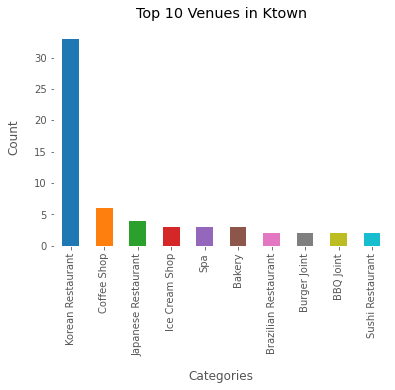

<Figure size 432x288 with 0 Axes>

In [99]:
my_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", 
             "#d62728", "#9467bd", "#8c564b", 
             "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"] # specifying the color list
nearby_venues['categories'].value_counts()[0:10].plot(kind='bar',color = my_colors)
plt.xlabel("Categories", labelpad=14)
plt.ylabel("Count", labelpad=14)
plt.title("Top 10 Venues in Ktown", y=1.02)

# set the background color to white
fig = plt.figure()
fig.patch.set_facecolor('white')

## 2. Explore Neighborhood in La


In [100]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        # this line used to get all the venue info
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        # each neighborhood may contain several different venues
        venues_list.append([(
            name, # neighborhood name
            lat,  # neighborhood lat
            lng,  # neighborhood lng
            v['venue']['name'],  # venue name
            v['venue']['location']['lat'],  # venue lat
            v['venue']['location']['lng'],  # venue lng
            v['venue']['categories'][0]['name']) for v in results]) # venue category

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [101]:
la_venues = getNearbyVenues(names=df_la['Neighborhood'],
                                   latitudes=df_la['Latitude'],
                                   longitudes=df_la['Longitude']
                                  )

Acton
Adams-Normandie
Agoura Hills
Agua Dulce
Alhambra
Alondra Park
Artesia
Altadena
Angeles Crest
Arcadia
Arleta
Arlington Heights
Athens
Atwater Village
Avalon
Avocado Heights
Azusa
Vermont-Slauson
Baldwin Hills/Crenshaw
Baldwin Park
Bel-Air
Bellflower
Bell Gardens
Green Valley
Bell
Beverly Crest
Beverly Grove
Burbank
Koreatown
Beverly Hills
Beverlywood
Boyle Heights
Bradbury
Brentwood
Broadway-Manchester
Calabasas
Canoga Park
Carson
Carthay
Castaic Canyons
Chatsworth
Castaic
Central-Alameda
Century City
Cerritos
Charter Oak
Chatsworth Reservoir
Chesterfield Square
Cheviot Hills
Chinatown
Citrus
Claremont
Northridge
Commerce
Compton
Cypress Park
La Mirada
Covina
Cudahy
Culver City
Del Aire
Del Rey
Desert View Highlands
Diamond Bar
Downey
Downtown
Duarte
Eagle Rock
East Compton
East Hollywood
East La Mirada
Elizabeth Lake
East Los Angeles
East Pasadena
East San Gabriel
Echo Park
El Monte
El Segundo
El Sereno
Elysian Park
Elysian Valley
Vermont Square
Encino
Exposition Park
Fairfax
Flo

In [102]:
print(la_venues.shape)
la_venues.head(10)

(21414, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Acton,34.497355,-118.16981,Crazy Otto's Diner,34.490733,-118.162548,Breakfast Spot
1,Acton,34.497355,-118.16981,La Cabaña,34.479308,-118.166997,Mexican Restaurant
2,Acton,34.497355,-118.16981,SUBWAY,34.493552,-118.188909,Sandwich Place
3,Acton,34.497355,-118.16981,Epik Engineering,34.498718,-118.168046,Construction & Landscaping
4,Acton,34.497355,-118.16981,Alma Gardening Co.,34.494762,-118.172550,Construction & Landscaping
5,Acton,34.497355,-118.16981,Grizzly Bears Burgers,34.490076,-118.162006,Burger Joint
6,Acton,34.497355,-118.16981,Acton Fitness,34.490093,-118.161253,Gym
7,Acton,34.497355,-118.16981,Perkin' Up Coffee House,34.490303,-118.160742,Café
8,Acton,34.497355,-118.16981,Dancin In Acton,34.490303,-118.160742,Arts & Entertainment
9,Acton,34.497355,-118.16981,The Rustic Cafe & Bakery,34.490163,-118.160684,Café


#### Let's check how many venues were returned for each neighborhood

In [103]:
la_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acton,13,13,13,13,13,13
Adams-Normandie,100,100,100,100,100,100
Agoura Hills,70,70,70,70,70,70
Agua Dulce,16,16,16,16,16,16
Alhambra,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [104]:
print('There are {} uniques categories.'.format(len(la_venues['Venue Category'].unique())))

There are 452 uniques categories.


## 3. Analyze Each Neighborhood

In [105]:
# one hot encoding
la_onehot = pd.get_dummies(la_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_onehot['Neighborhood'] = la_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = list(la_onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
la_onehot = la_onehot.loc[:,cols]

la_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Casino,Castle,Cave,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Classroom,College Football Field,College Gym,College Quad,College Residence Hall,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mo

In [106]:
la_grouped = la_onehot.groupby('Neighborhood').mean().reset_index()
la_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Casino,Castle,Cave,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Classroom,College Football Field,College Gym,College Quad,College Residence Hall,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Distribution Center,Dive Bar,Dive Shop,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Mo

#### Let's print each neighborhood along with the top 5 most common venues

In [107]:
num_top_venues = 5

for hood in la_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = la_grouped[la_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acton----
                        venue  freq
0  Construction & Landscaping  0.15
1                        Café  0.15
2                Burger Joint  0.08
3       Outdoors & Recreation  0.08
4                Home Service  0.08


----Adams-Normandie----
                venue  freq
0  Mexican Restaurant  0.08
1   Korean Restaurant  0.07
2                Café  0.05
3      Science Museum  0.04
4         Pizza Place  0.04


----Agoura Hills----
                  venue  freq
0         Deli / Bodega  0.06
1  Fast Food Restaurant  0.04
2    Mexican Restaurant  0.04
3                  Park  0.04
4             BBQ Joint  0.03


----Agua Dulce----
                        venue  freq
0  Construction & Landscaping  0.12
1                        Park  0.12
2               Grocery Store  0.06
3                   Gift Shop  0.06
4                 Pizza Place  0.06


----Alhambra----
                venue  freq
0  Chinese Restaurant  0.07
1  Mexican Restaurant  0.05
2              Bakery  0.05
3    

                  venue  freq
0    Mexican Restaurant  0.09
1                  Park  0.08
2           Coffee Shop  0.06
3        Sandwich Place  0.05
4  Fast Food Restaurant  0.05


----Del Aire----
                    venue  freq
0             Coffee Shop  0.07
1                     Gym  0.05
2           Grocery Store  0.05
3      Mexican Restaurant  0.05
4  Furniture / Home Store  0.03


----Del Rey----
                 venue  freq
0   Mexican Restaurant  0.06
1          Coffee Shop  0.05
2        Grocery Store  0.05
3  American Restaurant  0.04
4               Bakery  0.04


----Desert View Highlands----
                  venue  freq
0        Clothing Store  0.08
1  Fast Food Restaurant  0.06
2           Coffee Shop  0.05
3      Department Store  0.04
4           Pizza Place  0.03


----Diamond Bar----
                   venue  freq
0            Pizza Place  0.08
1     Chinese Restaurant  0.08
2            Coffee Shop  0.06
3          Grocery Store  0.05
4  Vietnamese Restaurant  0.

4  Fast Food Restaurant  0.04


----Industry----
                  venue  freq
0    Mexican Restaurant  0.09
1  Fast Food Restaurant  0.07
2              Pharmacy  0.05
3      Asian Restaurant  0.05
4           Pizza Place  0.05


----Inglewood----
                  venue  freq
0    Mexican Restaurant  0.08
1  Fast Food Restaurant  0.06
2     Convenience Store  0.05
3           Pizza Place  0.05
4         Grocery Store  0.04


----Irwindale----
               venue  freq
0          Racetrack  0.08
1     Discount Store  0.06
2  Convenience Store  0.06
3        Flower Shop  0.04
4        Supermarket  0.04


----Jefferson Park----
                       venue  freq
0                       Café  0.07
1         Mexican Restaurant  0.05
2  Latin American Restaurant  0.04
3             Sandwich Place  0.04
4           Sushi Restaurant  0.04


----Koreatown----
                 venue  freq
0    Korean Restaurant  0.33
1          Coffee Shop  0.06
2  Japanese Restaurant  0.04
3       Ice Cream 

4         Coffee Shop  0.03


----Panorama City----
                  venue  freq
0    Mexican Restaurant  0.08
1       Thai Restaurant  0.06
2  Fast Food Restaurant  0.06
3      Asian Restaurant  0.04
4              Pharmacy  0.04


----Paramount----
                  venue  freq
0  Fast Food Restaurant  0.10
1    Mexican Restaurant  0.09
2        Sandwich Place  0.09
3           Pizza Place  0.06
4     Convenience Store  0.06


----Pasadena----
           venue  freq
0    Pizza Place  0.07
1  Grocery Store  0.06
2    Coffee Shop  0.05
3       Dive Bar  0.04
4         Bakery  0.04


----Pico Rivera----
                  venue  freq
0    Mexican Restaurant  0.12
1  Fast Food Restaurant  0.07
2        Sandwich Place  0.05
3           Coffee Shop  0.05
4        Discount Store  0.05


----Pico-Robertson----
                 venue  freq
0                Hotel  0.08
1     Sushi Restaurant  0.05
2   Italian Restaurant  0.05
3          Coffee Shop  0.05
4  American Restaurant  0.04


----Pico

4                         ATM  0.00


----Unincorporated Santa Susana Mountains----
                   venue  freq
0         Scenic Lookout   1.0
1                    ATM   0.0
2            Pet Service   0.0
3     Persian Restaurant   0.0
4  Performing Arts Venue   0.0


----Universal City----
                          venue  freq
0                    Theme Park  0.14
1  Theme Park Ride / Attraction  0.13
2         General Entertainment  0.05
3                Breakfast Spot  0.04
4      Mediterranean Restaurant  0.03


----University Park----
                  venue  freq
0  Fast Food Restaurant  0.07
1          Burger Joint  0.05
2        Science Museum  0.05
3    Mexican Restaurant  0.05
4        Sandwich Place  0.04


----Val Verde----
              venue  freq
0              Food  0.17
1     Movie Theater  0.17
2              Park  0.17
3      Home Service  0.17
4  Business Service  0.17


----Valinda----
                  venue  freq
0  Fast Food Restaurant  0.08
1           Pizza

#### Let's put that into a _pandas_ dataframe

In [128]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [129]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues): # np.arange returns evenly spaced values within a given interval.
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = la_grouped['Neighborhood']

for ind in np.arange(la_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton,Construction & Landscaping,Café,Outdoors & Recreation,Arts & Entertainment,Gym,Sushi Restaurant,Sandwich Place,Mexican Restaurant,Home Service,Breakfast Spot
1,Adams-Normandie,Mexican Restaurant,Korean Restaurant,Café,Pizza Place,Science Museum,Coffee Shop,Taco Place,Breakfast Spot,Museum,Fast Food Restaurant
2,Agoura Hills,Deli / Bodega,Mexican Restaurant,Park,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,Hotel,Gym,Gas Station,Furniture / Home Store
3,Agua Dulce,Construction & Landscaping,Park,Business Service,Bakery,Grocery Store,Trail,Pizza Place,Café,Restaurant,Mexican Restaurant
4,Alhambra,Chinese Restaurant,Mexican Restaurant,Bakery,Italian Restaurant,Park,Dessert Shop,Burger Joint,Vietnamese Restaurant,Grocery Store,Convenience Store


## 4. Cluster Neighborhoods

### Before we dive into Kmeans itself, let's first tune our K value a little bit 

In [110]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


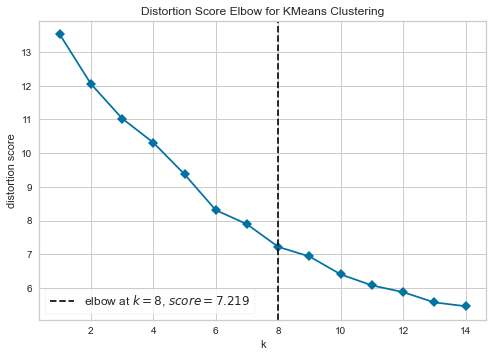

<Figure size 576x396 with 0 Axes>

In [111]:
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
la_grouped_clustering = la_grouped.drop('Neighborhood', 1)

# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,15), timings=False)
visualizer.fit(la_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
fig = plt.figure()
fig.patch.set_facecolor('black')

In [130]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 7, 5, 1, 7], dtype=int32)

In [131]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

la_merged = df_la

# merge la_grouped with df_la to add latitude/longitude for each neighborhood
la_merged = la_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

la_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton,34.497355,-118.169810,1.0,Construction & Landscaping,Café,Outdoors & Recreation,Arts & Entertainment,Gym,Sushi Restaurant,Sandwich Place,Mexican Restaurant,Home Service,Breakfast Spot
1,Adams-Normandie,34.031461,-118.300208,1.0,Mexican Restaurant,Korean Restaurant,Café,Pizza Place,Science Museum,Coffee Shop,Taco Place,Breakfast Spot,Museum,Fast Food Restaurant
2,Agoura Hills,34.146736,-118.759884,1.0,Deli / Bodega,Mexican Restaurant,Park,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,Hotel,Gym,Gas Station,Furniture / Home Store
3,Agua Dulce,34.504927,-118.317104,1.0,Construction & Landscaping,Park,Business Service,Bakery,Grocery Store,Trail,Pizza Place,Café,Restaurant,Mexican Restaurant
4,Alhambra,34.085539,-118.136512,1.0,Chinese Restaurant,Mexican Restaurant,Bakery,Italian Restaurant,Park,Dessert Shop,Burger Joint,Vietnamese Restaurant,Grocery Store,Convenience Store


In [132]:
la_merged = la_merged.dropna()
la_merged['Cluster Labels'] = la_merged['Cluster Labels'].astype(int)
la_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton,34.497355,-118.169810,1,Construction & Landscaping,Café,Outdoors & Recreation,Arts & Entertainment,Gym,Sushi Restaurant,Sandwich Place,Mexican Restaurant,Home Service,Breakfast Spot
1,Adams-Normandie,34.031461,-118.300208,1,Mexican Restaurant,Korean Restaurant,Café,Pizza Place,Science Museum,Coffee Shop,Taco Place,Breakfast Spot,Museum,Fast Food Restaurant
2,Agoura Hills,34.146736,-118.759884,1,Deli / Bodega,Mexican Restaurant,Park,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,Hotel,Gym,Gas Station,Furniture / Home Store
3,Agua Dulce,34.504927,-118.317104,1,Construction & Landscaping,Park,Business Service,Bakery,Grocery Store,Trail,Pizza Place,Café,Restaurant,Mexican Restaurant
4,Alhambra,34.085539,-118.136512,1,Chinese Restaurant,Mexican Restaurant,Bakery,Italian Restaurant,Park,Dessert Shop,Burger Joint,Vietnamese Restaurant,Grocery Store,Convenience Store


In [133]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['Neighborhood'], la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [134]:
Cluster0 = la_merged.loc[la_merged['Cluster Labels'] == 0, la_merged.columns[[0] + list(range(3, la_merged.shape[1]))]]
Cluster0

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Bel-Air,0,Trail,Grocery Store,Hotel Bar,Hotel,Historic Site,Intersection,Light Rail Station,Garden,Office,Park
33,Brentwood,0,Trail,Art Museum,Art Gallery,Café,Garden,Mountain,Playground,Building,Gift Shop,Scenic Lookout
35,Calabasas,0,Trail,Intersection,Golf Course,Health & Beauty Service,Auto Dealership,Moving Target,Mountain,Campground,English Restaurant,Empanada Restaurant
94,Granada Hills,0,Trail,Park,Pharmacy,Spa,Soccer Field,Shopping Mall,Shipping Store,Donut Shop,Baseball Field,Bar
95,Griffith Park,0,Trail,Zoo Exhibit,Park,Scenic Lookout,Golf Course,Mountain,Gift Shop,Performing Arts Venue,Theme Park,Tennis Court
127,Lake Hughes,0,Trail,Arcade,American Restaurant,Pub,Business Service,Campground,Farm,Fair,Factory,Fabric Shop
147,Malibu,0,Beach,Trail,Seafood Restaurant,Surf Spot,Park,Campground,Restaurant,Auto Garage,Greek Restaurant,Ethiopian Restaurant
168,North Whittier,0,Trail,Flower Shop,Construction & Landscaping,Restaurant,College Bookstore,Electronics Store,Paintball Field,Motorsports Shop,Gas Station,Theater
170,Pacific Palisades,0,Trail,Pool,Nightlife Spot,Campground,Gym,Italian Restaurant,Waterfall,Furniture / Home Store,Scenic Lookout,Nature Preserve
194,Rolling Hills,0,Trail,Italian Restaurant,Park,Mexican Restaurant,Flower Shop,Coffee Shop,Salon / Barbershop,Bagel Shop,Sandwich Place,Baseball Field


In [135]:
Cluster1 = la_merged.loc[la_merged['Cluster Labels'] == 1, la_merged.columns[[0] + list(range(3, la_merged.shape[1]))]]
Cluster1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton,1,Construction & Landscaping,Café,Outdoors & Recreation,Arts & Entertainment,Gym,Sushi Restaurant,Sandwich Place,Mexican Restaurant,Home Service,Breakfast Spot
1,Adams-Normandie,1,Mexican Restaurant,Korean Restaurant,Café,Pizza Place,Science Museum,Coffee Shop,Taco Place,Breakfast Spot,Museum,Fast Food Restaurant
2,Agoura Hills,1,Deli / Bodega,Mexican Restaurant,Park,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,Hotel,Gym,Gas Station,Furniture / Home Store
3,Agua Dulce,1,Construction & Landscaping,Park,Business Service,Bakery,Grocery Store,Trail,Pizza Place,Café,Restaurant,Mexican Restaurant
4,Alhambra,1,Chinese Restaurant,Mexican Restaurant,Bakery,Italian Restaurant,Park,Dessert Shop,Burger Joint,Vietnamese Restaurant,Grocery Store,Convenience Store
5,Alondra Park,1,Fast Food Restaurant,Convenience Store,Pharmacy,Burger Joint,Grocery Store,Vietnamese Restaurant,Korean Restaurant,Sushi Restaurant,Noodle House,Park
6,Artesia,1,Indian Restaurant,Grocery Store,Chinese Restaurant,Filipino Restaurant,Coffee Shop,Bakery,Café,BBQ Joint,Thai Restaurant,Ice Cream Shop
9,Arcadia,1,Mexican Restaurant,Bakery,Fast Food Restaurant,Sandwich Place,Chinese Restaurant,Pizza Place,Breakfast Spot,Dessert Shop,American Restaurant,Garden
11,Arlington Heights,1,Korean Restaurant,Mexican Restaurant,Sandwich Place,Grocery Store,BBQ Joint,Caribbean Restaurant,Art Gallery,Japanese Restaurant,Dessert Shop,Brazilian Restaurant
13,Atwater Village,1,Bakery,Café,Gym,Middle Eastern Restaurant,Cosmetics Shop,Mediterranean Restaurant,Coffee Shop,Toy / Game Store,Asian Restaurant,Ice Cream Shop


In [124]:
Cluster2 = la_merged.loc[la_merged['Cluster Labels'] == 2, la_merged.columns[[0] + list(range(3, la_merged.shape[1]))]]
Cluster2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
193,Ridge Route,2,Road,Zoo Exhibit,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant


In [125]:
Cluster3 = la_merged.loc[la_merged['Cluster Labels'] == 3, la_merged.columns[[0] + list(range(3, la_merged.shape[1]))]]
Cluster3

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
246,Unincorporated Santa Susana Mountains,3,Scenic Lookout,Zoo Exhibit,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant


In [126]:
Cluster4 = la_merged.loc[la_merged['Cluster Labels'] == 4, la_merged.columns[[0] + list(range(3, la_merged.shape[1]))]]
Cluster4

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Castaic Canyons,4,Trail,Zoo Exhibit,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant
242,Unincorporated Santa Monica Mountains,4,Trail,Construction & Landscaping,State / Provincial Park,Lake,Fair,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service


In [59]:
Cluster5 = la_merged.loc[la_merged['Cluster Labels'] == 5, la_merged.columns[[0] + list(range(3, la_merged.shape[1]))]]
Cluster5

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Adams-Normandie,5,Sushi Restaurant,Park,Home Service,Gas Station,Playground,Grocery Store,Taco Place,Falafel Restaurant,Empanada Restaurant,English Restaurant
2,Agoura Hills,5,Fast Food Restaurant,Chinese Restaurant,Breakfast Spot,Restaurant,Thai Restaurant,Liquor Store,Lounge,Sushi Restaurant,Bakery,Shipping Store
5,Alondra Park,5,Park,Baseball Field,Home Service,Fast Food Restaurant,Escape Room,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market
6,Artesia,5,Indian Restaurant,Chinese Restaurant,Bubble Tea Shop,Vietnamese Restaurant,Salon / Barbershop,Taiwanese Restaurant,Tea Room,Sandwich Place,Thai Restaurant,Gift Shop
7,Altadena,5,Notary,Campground,Pharmacy,Bakery,Food,Flea Market,Fish & Chips Shop,Financial or Legal Service,Film Studio,Filipino Restaurant
9,Arcadia,5,Gym,Cosmetics Shop,Convenience Store,Tea Room,Ice Cream Shop,Coffee Shop,Chinese Restaurant,Shabu-Shabu Restaurant,Fast Food Restaurant,Food & Drink Shop
10,Arleta,5,Home Service,Convenience Store,Historic Site,Video Store,Bakery,Yoga Studio,Fast Food Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant
11,Arlington Heights,5,Korean Restaurant,Karaoke Bar,Mexican Restaurant,Latin American Restaurant,Vegetarian / Vegan Restaurant,Donut Shop,Home Service,Food,Café,Music Venue
13,Atwater Village,5,Taco Place,Ice Cream Shop,Pizza Place,Pharmacy,Other Repair Shop,Mobile Phone Shop,Mexican Restaurant,Mediterranean Restaurant,Juice Bar,Gym / Fitness Center
16,Azusa,5,Thrift / Vintage Store,Liquor Store,Big Box Store,Coffee Shop,Pizza Place,Pharmacy,Farm,Escape Room,Ethiopian Restaurant,Fabric Shop


In [69]:
Cluster6 = la_merged.loc[la_merged['Cluster Labels'] == 6, la_merged.columns[[0] + list(range(3, la_merged.shape[1]))]]
Cluster6

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Agua Dulce,6,Airport,Yoga Studio,Filipino Restaurant,Escape Room,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


In [70]:
Cluster7 = la_merged.loc[la_merged['Cluster Labels'] == 7, la_merged.columns[[0] + list(range(3, la_merged.shape[1]))]]
Cluster7

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
96,Hacienda Heights,7,Park,Scenic Lookout,Yoga Studio,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm
112,Hollywood Hills,7,Scenic Lookout,Trail,Bus Station,Park,Yoga Studio,Farm,English Restaurant,Escape Room,Ethiopian Restaurant,Fabric Shop
198,San Dimas,7,Scenic Lookout,Yoga Studio,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market
252,Walnut,7,Scenic Lookout,Farm,Yoga Studio,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market


## 5. Get the top 10 venue categories for each cluster

In [71]:
la_grouped_copy = la_grouped.copy()
la_grouped_copy.head()

,Neighborhood,ATM,Accessories Store,Airport,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Residence Hall,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,High School,Historic Site,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Notary,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Superm

In [72]:
la_grouped_copy.insert(1, 'Cluster Labels', kmeans.labels_)
la_grouped_copy.head()

,Neighborhood,Cluster Labels,ATM,Accessories Store,Airport,Airport Terminal,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Residence Hall,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,High School,Historic Site,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Notary,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stables,State / Provincial Park,Steakhouse,Storage Facility,St

In [73]:
la_grouped_copy = la_grouped_copy.groupby('Cluster Labels').sum()
la_grouped_copy = la_grouped_copy.T
la_grouped_copy.head()

Cluster Labels,0,1,2,3,4,5,6,7
ATM,0.0,0.207576,0.0,0.0,0.0,0.489081,0.0,0.0
Accessories Store,0.0,0.000000,0.0,0.0,0.0,0.129231,0.0,0.0
Airport,0.0,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0
Airport Terminal,0.0,0.000000,0.0,0.0,0.0,0.022727,0.0,0.0
American Restaurant,0.0,0.443603,0.0,0.0,0.0,1.891412,0.0,0.0


#### Get the top 10 out of each cluster

In [74]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches

mpl.style.use('ggplot') # optional: for ggplot-like style
colors_list = ['#5cb85c','#5bc0de','#d9534f']

In [75]:
C0 = la_grouped_copy[[0]]
C0 = C0.sort_values(by=0,ascending=False)
C0_head = C0[:10] # create a new dataframe which only has the first 10 rows
C0_head[['%']] = round(C0_head[[0]]/C0_head.sum(),2)*100 # get the percent for each venue
C0_head

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Cluster Labels,0,%
Construction & Landscaping,3.5,88.0
Home Service,0.5,12.0
ATM,0.0,0.0
Optical Shop,0.0,0.0
Performing Arts Venue,0.0,0.0
Pedestrian Plaza,0.0,0.0
Park,0.0,0.0
Paper / Office Supplies Store,0.0,0.0
Other Repair Shop,0.0,0.0
Other Great Outdoors,0.0,0.0


### Plot the top 10 venue for Cluster 0

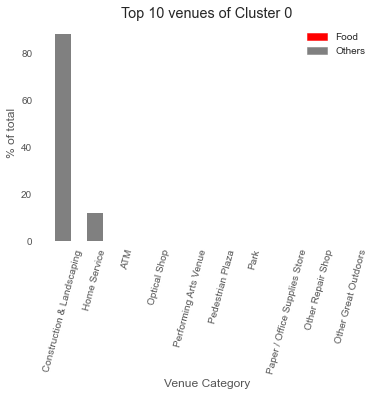

In [76]:
index = C0_head.index.tolist() # create a list which contains all the venues and use it as the index of our plot
values = C0_head['%'].tolist() # create a list which contains all the frequencies 
clrs = ['red' if (i == 'Food' or i == 'Sushi Restaurant') else 'grey' for i in index]
fig, ax = plt.subplots()
ax.bar(index, values, width=0.5, color=clrs) 
ax.set_xlabel('Venue Category') 
ax.set_ylabel('% of total') 
ax.set_facecolor('white') #set the background color
plt.xticks(rotation=75)

# customize the legend
Food = mpatches.Patch(color='red',label='Food')
Other = mpatches.Patch(color='grey',label='Others')
plt.legend(handles=[Food,Other], loc=1)
plt.title('Top 10 venues of Cluster 0')
plt.show()

### Plot the top 10 venue for Cluster 1

In [77]:
C1 = la_grouped_copy[[1]]
C1 = C1.sort_values(by=1,ascending=False)
C1_head = C1[:10] # create a new dataframe which only has the first 10 rows
C1_head[['%']] = round(C1_head[[1]]/C1_head.sum(),2)*100 # get the percent for each venue
C1_head

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Cluster Labels,1,%
Mexican Restaurant,7.862890,25.0
Fast Food Restaurant,4.531483,14.0
Convenience Store,4.126088,13.0
Pizza Place,3.701964,12.0
Food Truck,3.669444,11.0
Park,2.494517,8.0
Donut Shop,1.716126,5.0
Liquor Store,1.564894,5.0
Sandwich Place,1.288121,4.0
Pharmacy,1.010917,3.0


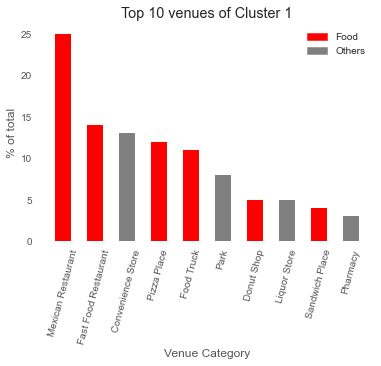

In [80]:
index = C1_head.index.tolist() # create a list which contains all the venues and use it as the index of our plot
values = C1_head['%'].tolist() # create a list which contains all the frequencies 
clrs = ['red' if (i == 'Mexican Restaurant' 
                  or i == 'Fast Food Restaurant' 
                  or i == 'Pizza Place'
                  or i == 'Food Truck'
                  or i == 'Donut Shop'
                  or i == 'Sandwich Place') else 'grey' for i in index]
fig, ax = plt.subplots()
ax.bar(index, values, width=0.5, color=clrs) 
ax.set_xlabel('Venue Category') 
ax.set_ylabel('% of total') 
ax.set_facecolor('white') #set the background color
plt.xticks(rotation=75)

# customize the legend
Food = mpatches.Patch(color='red',label='Food')
Other = mpatches.Patch(color='grey',label='Others')
plt.legend(handles=[Food,Other], loc=1)
plt.title('Top 10 venues of Cluster 1')
plt.show()

### Plot the top 10 venue for Cluster 2

In [81]:
C2 = la_grouped_copy[[2]]
C2 = C2.sort_values(by=2,ascending=False)
C2_head = C2[:10] # create a new dataframe which only has the first 10 rows
C2_head[['%']] = round(C2_head[[2]]/C2_head.sum(),2)*100 # get the percent for each venue
C2_head

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Cluster Labels,2,%
Park,8.166667,68.0
Lake,1.000000,8.0
Food,0.750000,6.0
Church,0.500000,4.0
Pool,0.500000,4.0
Other Repair Shop,0.500000,4.0
Home Service,0.333333,3.0
Music Venue,0.250000,2.0
Pub,0.000000,0.0
Pedestrian Plaza,0.000000,0.0


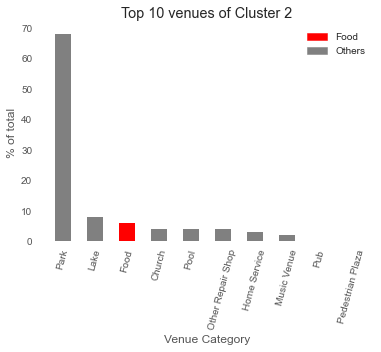

In [82]:
index = C2_head.index.tolist() # create a list which contains all the venues and use it as the index of our plot
values = C2_head['%'].tolist() # create a list which contains all the frequencies 
clrs = ['red' if (i == 'Food' or i == 'Mexican Restaurant' or i == 'Fried Chicken Joint') else 'grey' for i in index]
fig, ax = plt.subplots()
ax.bar(index, values, width=0.5, color=clrs) 
ax.set_xlabel('Venue Category') 
ax.set_ylabel('% of total') 
ax.set_facecolor('white') #set the background color
plt.xticks(rotation=75)

# customize the legend
Food = mpatches.Patch(color='red',label='Food')
Other = mpatches.Patch(color='grey',label='Others')
plt.legend(handles=[Food,Other], loc=1)
plt.title('Top 10 venues of Cluster 2')
plt.show()

### Plot the top 10 venue for Cluster 3

In [83]:
C3 = la_grouped_copy[[3]]
C3 = C3.sort_values(by=3,ascending=False)
C3_head = C3[:10] # create a new dataframe which only has the first 10 rows
C3_head[['%']] = round(C3_head[[3]]/C3_head.sum(),2)*100 # get the percent for each venue
C3_head

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Cluster Labels,3,%
Business Service,2.0,100.0
ATM,0.0,0.0
Office,0.0,0.0
Pedestrian Plaza,0.0,0.0
Park,0.0,0.0
Paper / Office Supplies Store,0.0,0.0
Other Repair Shop,0.0,0.0
Other Great Outdoors,0.0,0.0
Organic Grocery,0.0,0.0
Optical Shop,0.0,0.0


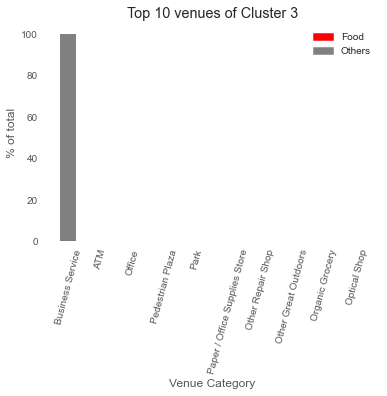

In [84]:
index = C3_head.index.tolist() # create a list which contains all the venues and use it as the index of our plot
values = C3_head['%'].tolist() # create a list which contains all the frequencies 
clrs = ['red' if (i == 'Cafe' or i == 'Fast Food Restaurant' or i == 'Food Truck' or i == 'Food' or i=='Pizza Place') else 'grey' for i in index]
fig, ax = plt.subplots()
ax.bar(index, values, width=0.5, color=clrs) 
ax.set_xlabel('Venue Category') 
ax.set_ylabel('% of total') 
ax.set_facecolor('white') #set the background color
plt.xticks(rotation=75)

# customize the legend
Food = mpatches.Patch(color='red',label='Food')
Other = mpatches.Patch(color='grey',label='Others')
plt.legend(handles=[Food,Other], loc=1)
plt.title('Top 10 venues of Cluster 3')
plt.show()

### Plot the top 10 venue for Cluster 4

In [85]:
C4 = la_grouped_copy[[4]]
C4 = C4.sort_values(by=4,ascending=False)
C4_head = C4[:10] # create a new dataframe which only has the first 10 rows
C4_head[['%']] = round(C4_head[[4]]/C4_head.sum(),2)*100 # get the percent for each venue
C4_head

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Cluster Labels,4,%
Trail,4.066667,68.0
Lake,0.500000,8.0
Pharmacy,0.333333,6.0
Park,0.250000,4.0
Garden,0.250000,4.0
Gourmet Shop,0.200000,3.0
Coffee Shop,0.200000,3.0
Other Repair Shop,0.200000,3.0
Organic Grocery,0.000000,0.0
Pedestrian Plaza,0.000000,0.0


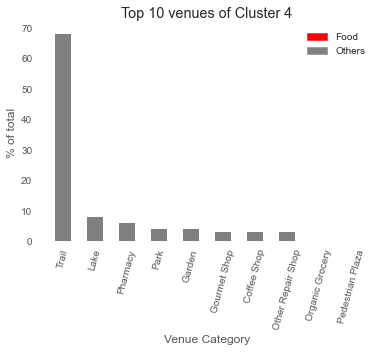

In [86]:
index = C4_head.index.tolist() # create a list which contains all the venues and use it as the index of our plot
values = C4_head['%'].tolist() # create a list which contains all the frequencies 
clrs = ['red' if (i == 'Mexican Restaurant' or i == 'Burger Joint' 
                  or i == 'Food Truck' 
                  or i == 'Fast Food Restaurant' 
                  or i == 'Pizza Place'
                  or i == 'Latin American Restaurant'
                  or i == 'Food') else 'grey' for i in index]
fig, ax = plt.subplots()
ax.bar(index, values, width=0.5, color=clrs) 
ax.set_xlabel('Venue Category') 
ax.set_ylabel('% of total') 
ax.set_facecolor('white') #set the background color
plt.xticks(rotation=75)

# customize the legend
Food = mpatches.Patch(color='red',label='Food')
Other = mpatches.Patch(color='grey',label='Others')
plt.legend(handles=[Food,Other], loc=1)
plt.title('Top 10 venues of Cluster 4')
plt.show()

### Plot the top 10 venue for Cluster 5

In [87]:
C5 = la_grouped_copy[[5]]
C5 = C5.sort_values(by=5,ascending=False)
C5_head = C5[:10] # create a new dataframe which only has the first 10 rows
C5_head[['%']] = round(C5_head[[5]]/C5_head.sum(),2)*100 # get the percent for each venue
C5_head

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Cluster Labels,5,%
Grocery Store,5.659286,16.0
Home Service,4.145654,12.0
Burger Joint,4.047818,12.0
Café,3.759031,11.0
Bakery,3.652286,10.0
Park,2.856549,8.0
Food,2.789063,8.0
Clothing Store,2.721271,8.0
Coffee Shop,2.595637,7.0
Convenience Store,2.590992,7.0


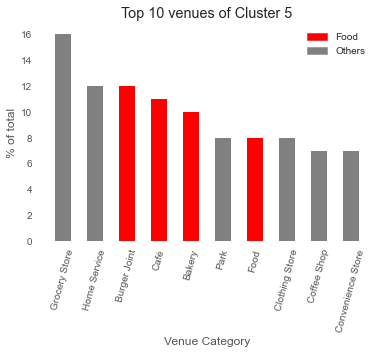

In [88]:
index = C5_head.index.tolist() # create a list which contains all the venues and use it as the index of our plot
values = C5_head['%'].tolist() # create a list which contains all the frequencies 
clrs = ['red' if (i == 'Café' 
                  or i == 'Burger Joint' 
                  or i == 'Bakery' 
                  or i == 'Food') else 'grey' for i in index]
fig, ax = plt.subplots()
ax.bar(index, values, width=0.5, color=clrs) 
ax.set_xlabel('Venue Category') 
ax.set_ylabel('% of total') 
ax.set_facecolor('white') #set the background color
plt.xticks(rotation=75)

# customize the legend
Food = mpatches.Patch(color='red',label='Food')
Other = mpatches.Patch(color='grey',label='Others')
plt.legend(handles=[Food,Other], loc=1)
plt.title('Top 10 venues of Cluster 5')
plt.show()

### Plot the top 10 venue for Cluster 6

In [89]:
C6 = la_grouped_copy[[6]]
C6 = C6.sort_values(by=6,ascending=False)
C6_head = C6[:10] # create a new dataframe which only has the first 10 rows
C6_head[['%']] = round(C6_head[[6]]/C6_head.sum(),2)*100 # get the percent for each venue
C6_head

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Cluster Labels,6,%
Airport,1.0,100.0
ATM,0.0,0.0
Office,0.0,0.0
Pedestrian Plaza,0.0,0.0
Park,0.0,0.0
Paper / Office Supplies Store,0.0,0.0
Other Repair Shop,0.0,0.0
Other Great Outdoors,0.0,0.0
Organic Grocery,0.0,0.0
Optical Shop,0.0,0.0


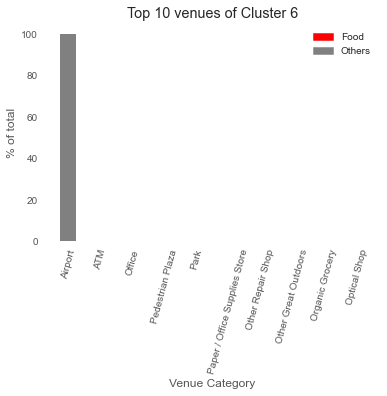

In [90]:
index = C6_head.index.tolist() # create a list which contains all the venues and use it as the index of our plot
values = C6_head['%'].tolist() # create a list which contains all the frequencies 
clrs = ['red' if (i == 'Mexican Restaurant' or i == 'Burger Joint' 
                  or i == 'Food Truck' 
                  or i == 'Fast Food Restaurant' 
                  or i == 'Pizza Place'
                  or i == 'Latin American Restaurant'
                  or i == 'Food') else 'grey' for i in index]
fig, ax = plt.subplots()
ax.bar(index, values, width=0.5, color=clrs) 
ax.set_xlabel('Venue Category') 
ax.set_ylabel('% of total') 
ax.set_facecolor('white') #set the background color
plt.xticks(rotation=75)

# customize the legend
Food = mpatches.Patch(color='red',label='Food')
Other = mpatches.Patch(color='grey',label='Others')
plt.legend(handles=[Food,Other], loc=1)
plt.title('Top 10 venues of Cluster 6')
plt.show()

### Plot the top 10 venue for Cluster 6

In [91]:
C7 = la_grouped_copy[[7]]
C7 = C7.sort_values(by=7,ascending=False)
C7_head = C7[:10] # create a new dataframe which only has the first 10 rows
C7_head[['%']] = round(C7_head[[7]]/C7_head.sum(),2)*100 # get the percent for each venue
C7_head

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Cluster Labels,7,%
Scenic Lookout,2.4,60.0
Park,0.7,18.0
Farm,0.5,12.0
Bus Station,0.2,5.0
Trail,0.2,5.0
ATM,0.0,0.0
Organic Grocery,0.0,0.0
Pedestrian Plaza,0.0,0.0
Paper / Office Supplies Store,0.0,0.0
Other Repair Shop,0.0,0.0


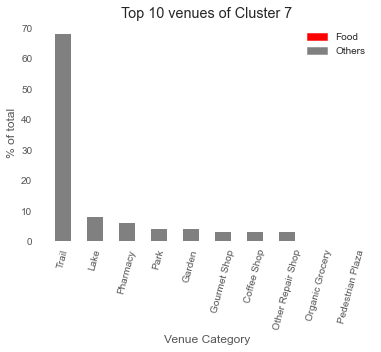

In [257]:
index = C7_head.index.tolist() # create a list which contains all the venues and use it as the index of our plot
values = C7_head['%'].tolist() # create a list which contains all the frequencies 
clrs = ['red' if (i == 'Mexican Restaurant' or i == 'Burger Joint' 
                  or i == 'Food Truck' 
                  or i == 'Fast Food Restaurant' 
                  or i == 'Pizza Place'
                  or i == 'Latin American Restaurant'
                  or i == 'Food') else 'grey' for i in index]
fig, ax = plt.subplots()
ax.bar(index, values, width=0.5, color=clrs) 
ax.set_xlabel('Venue Category') 
ax.set_ylabel('% of total') 
ax.set_facecolor('white') #set the background color
plt.xticks(rotation=75)

# customize the legend
Food = mpatches.Patch(color='red',label='Food')
Other = mpatches.Patch(color='grey',label='Others')
plt.legend(handles=[Food,Other], loc=1)
plt.title('Top 10 venues of Cluster 7')
plt.show()

From the all the graphs above we can say that the proper neighborhood for opening up a new resaturant would come from __Custer 0__ , __Cluster 2__ and __Cluster 7__.

In [517]:
# create a new dataframe which includes all the candidate neighborhood
candidates = pd.concat([Cluster0,Cluster2,Cluster7]).reset_index()
candidates = candidates[['Neighborhood']]
candidates = candidates.drop(32) #drop the last row which is unincroporated
candidates

,Neighborhood
0,Adams-Normandie
1,Alondra Park
2,Green Valley
3,Bradbury
4,Charter Oak
5,Hancock Park
6,Lynwood
7,Pacoima
8,South San Jose Hills
9,Sunland


### Manually get all the info of candidates from internet 

In [518]:
# number of people
population = [18504, 8097, 1572, 916, 9760, 10304, 71022, 78478, 20593, 15797, 
              36352, 90, 30385, 43401, 47887, 54970, 22640, 58694, 24010, 32358, 
              19281, 16497, 68306, 20727, 2996, 33980, 22624, 200372, 12506, 42271,
              11006, 27978]

# people/square mile
population_density = [21948, 7518.4, 80.2, 562, 10034, 6459, 14445, 10510, 13628.8, 1034, 
                      4038, 22, 10446, 18760, 13478, 4832.4, 3063, 19161, 16300, 3797, 2890.8,
                      8422, 8174, 7329, 962.1, 2163.1, 5818.6, 6373, 6878, 3092.6, 3663, 23842]

# one year change in percentage
population_growth = [-7, 8.82, 19.6, -7.66, 2.94, -6, -0.42, 0.01, 0.832, None, 0.309, 18.4,
                     None, None, None, 1.5, 8.81, -3.1, None, 0.118, 0.1, None, None, 0.0724, 0, None,
                     None, 6.8, 1.24, 3.83, 3.85, None]

Median_Household_Income = [44190, 63368, 111884, 154000, 75371, 116984, 49684, 58522, 
                           64302, 79593, 83471, 70000, 45214, 40274, 51421, 84219, 99601, 40638,
                           46422, 85769, 75016, 65369, 50774, 48944, 85208, 84749, 49256, 62531,
                           85702, 133286, 96630, 66011]

Median_Rent = [1080, 1144, 1280, 3501, 1754, 2098, 1161, 1525 ,1542, 1701, 1977, None,  
               1224, 1127, 1148, 1793, 1752, 1028, 1176, 1458, 1744, 1362, 1401, 1256, 1158, 1727, 1881,
               1529, 1662, 2676, 1470, 1555]
crime_rate = ['C','D','A','B','D','C','C','C','F','B','C','F','C','C','B','D','C','C',
              'C','B','B','C','C','C','A','B','B','B','B','B','B','B']


In [519]:
candidates['population'] = population
candidates['population_density'] = population_density
candidates['population_growth'] = population_growth
candidates['Median_Household_Income'] = Median_Household_Income
candidates['Median_Rent'] = Median_Rent
candidates['Crime_rate'] = crime_rate
candidates.head()

,Neighborhood,population,population_density,population_growth,Median_Household_Income,Median_Rent,Crime_rate
0,Adams-Normandie,18504,21948.0,-7.00,44190,1080.0,C
1,Alondra Park,8097,7518.4,8.82,63368,1144.0,D
2,Green Valley,1572,80.2,19.60,111884,1280.0,A
3,Bradbury,916,562.0,-7.66,154000,3501.0,B
4,Charter Oak,9760,10034.0,2.94,75371,1754.0,D


In [520]:
# replace the null value
candidates['population_growth'].fillna((candidates['population_growth'].mean()), inplace=True)
candidates['Median_Rent'].fillna((candidates['Median_Rent'].mean()), inplace=True)

In [521]:
# convert the non-numeric value in crime_rate column to integer
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(candidates['Crime_rate'])
candidates['Crime_rate'] = enc.transform(candidates['Crime_rate'])
candidates['Crime_rate']+=1

In [522]:
# reserve the neighborhood column
Neighborhood = [x for x in candidates['Neighborhood']]

In [523]:
# drop the neighborhood column for normalize purpose
candidates = candidates.drop(columns=['Neighborhood'])

In [524]:
candidates.head()

,population,population_density,population_growth,Median_Household_Income,Median_Rent,Crime_rate
0,18504,21948.0,-7.00,44190,1080.0,3
1,8097,7518.4,8.82,63368,1144.0,4
2,1572,80.2,19.60,111884,1280.0,1
3,916,562.0,-7.66,154000,3501.0,2
4,9760,10034.0,2.94,75371,1754.0,4


In [525]:
# normalize data
normalized_candiates=(candidates-candidates.min())/(candidates.max()-candidates.min())
normalized_candiates['Neighborhood'] = Neighborhood
cols = list(normalized_candiates)

# move neighborhood column to the front
cols.insert(0, cols.pop(cols.index('Neighborhood')))
normalized_candiates = normalized_candiates.loc[:,cols]
normalized_candiates.head()

,Neighborhood,population,population_density,population_growth,Median_Household_Income,Median_Rent,Crime_rate
0,Adams-Normandie,0.091940,0.920487,0.024211,0.034434,0.021027,0.50
1,Alondra Park,0.039979,0.314710,0.604549,0.203067,0.046907,0.75
2,Green Valley,0.007400,0.002443,1.000000,0.629671,0.101901,0.00
3,Bradbury,0.004124,0.022670,0.000000,1.000000,1.000000,0.25
4,Charter Oak,0.048282,0.420319,0.388848,0.308610,0.293571,0.75


#### Because the higher the Median_rent, the cost for opening a new restaurant is higher, so we set '-1' as its coefficient. Same as Crime_rate

In [526]:
normalized_candiates['Median_Rent'] *= -1
normalized_candiates['Crime_rate'] *= -1

In [530]:
normalized_candiates['score'] = normalized_candiates.sum(axis=1)
normalized_candiates = normalized_candiates.sort_values(by=['score'], ascending=False)
normalized_candiates

,Neighborhood,population,population_density,population_growth,Median_Household_Income,Median_Rent,Crime_rate,score
27,Glendale,1.000000,0.266625,0.530448,0.195707,-0.202588,-0.25,6.160766
2,Green Valley,0.007400,0.002443,1.000000,0.629671,-0.101901,-0.00,6.150455
31,Tujunga,0.139244,1.000000,0.369458,0.226307,-0.213101,-0.25,5.087629
14,Cypress Park,0.238649,0.564903,0.369458,0.098016,-0.048524,-0.25,3.890009
13,Central-Alameda,0.216250,0.786650,0.369458,0.000000,-0.040032,-0.50,3.329303
17,Huntington Park,0.292607,0.803484,0.167278,0.003201,-0.000000,-0.50,3.066283
6,Lynwood,0.354161,0.605500,0.265591,0.082743,-0.053781,-0.50,3.016851
30,Sierra Madre,0.054503,0.152855,0.422230,0.495542,-0.178730,-0.25,2.785600
24,Val Verde,0.014510,0.039467,0.280998,0.395108,-0.052568,-0.00,2.710056
18,Jefferson Park,0.119432,0.683375,0.369458,0.054060,-0.059846,-0.50,2.665914


### Seems like Glendale is the best choice for us

In [158]:
score = [6.160766,
         6.150455,
         5.087629,
         3.890009,
         3.329303,
         3.066283,
         3.016851,
         2.785600,
         2.710056,
         2.665914]
neighborhood = ['Glendale',
                'Green Valley',
                'Tujunga',
                'Cypress Park',
                'Central-Alameda',
                'Huntington Park',
                'Lynwood',
                'Sierra Madre',
                'Val Verde',
                'Jefferson Park']

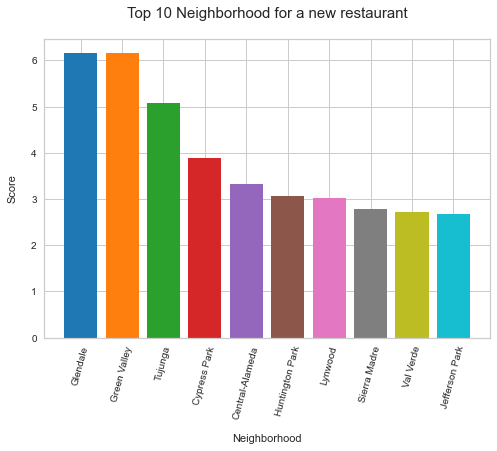

In [162]:
clrs = ["#1f77b4", "#ff7f0e", "#2ca02c", 
        "#d62728", "#9467bd", "#8c564b", 
        "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"] # specifying the color list

fig, ax = plt.subplots()
ax.bar(neighborhood,score,width=0.8,color=clrs) 
ax.set_xlabel('Neighborhood',labelpad=14) 
ax.set_ylabel('Score',labelpad=14) 
plt.xticks(rotation=75)
plt.title('Top 10 Neighborhood for a new restaurant',y=1.05,size=15)
plt.show()


In [170]:
import seaborn as sns
# Set dark grid
sns.set()
sns.set_style("white")

Text(0.5, 1.02, 'Top 10 neighborhood for a new restaurant')

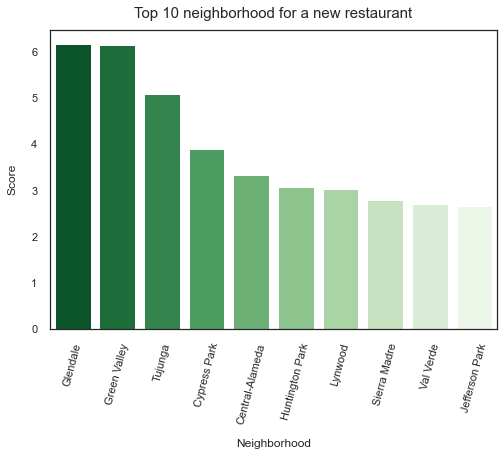

In [171]:
sns.barplot(x=neighborhood, y=score, palette='Greens_r')
plt.xticks(rotation=75)
plt.xlabel("Neighborhood", labelpad=14)
plt.ylabel("Score", labelpad=14)
plt.title("Top 10 neighborhood for a new restaurant", y=1.02, size = 15)